# HuBERT-ECG Demo Notebook (Fixed)

This notebook demonstrates how to use the HuBERT-ECG model for ECG classification. HuBERT-ECG is a self-supervised foundation model for broad and scalable cardiac applications.

## Overview

In this notebook, we will:
1. Load a pre-trained HuBERT-ECG model from Hugging Face
2. Prepare ECG data for inference
3. Run inference on the ECG data
4. Visualize the results

For more information, see the [HuBERT-ECG paper](https://www.medrxiv.org/content/10.1101/2024.11.14.24317328v1).

## Setup

First, let's import the necessary libraries and set up the environment.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoModel
from tqdm.notebook import tqdm

# Check if iterative-stratification is installed
try:
    import iterative_stratification
    print("iterative-stratification is installed")
except ImportError:
    print("Warning: iterative-stratification is not installed. Some functions in utils.py may not work.")
    print("You can install it with: pip install iterative-stratification")

# Add the code directory to the path
sys.path.append('code')

# Import HuBERT-ECG modules
from hubert_ecg import HuBERTECG, HuBERTECGConfig
from hubert_ecg_classification import HuBERTForECGClassification

# Import fixed functions
from fixed_hubert_ecg import preprocess_ecg, run_inference

# Define a simple load_model function to avoid importing from utils
def load_model(model_path, device):
    """Load a pre-trained HuBERT-ECG model from a file."""
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

You can install it with: pip install iterative-stratification
Using device: cpu


## Load Pre-trained Model

We'll load a pre-trained HuBERT-ECG model from Hugging Face. You can choose between the small, base, or large model.

In [2]:
# Choose model size: 'small', 'base', or 'large'
model_size = 'base'

# Load pre-trained model from Hugging Face
model_name = f"Edoardo-BS/hubert-ecg-{model_size}"
print(f"Loading model: {model_name}")

try:
    # Try to load the model directly from Hugging Face
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
    print("Model loaded successfully from Hugging Face")
except Exception as e:
    print(f"Error loading model from Hugging Face: {e}")
    print("Please download the model manually from https://huggingface.co/Edoardo-BS")
    # If you have downloaded the model locally, you can load it like this:
    # model_path = f"path/to/downloaded/hubert_ecg_{model_size}.pt"
    # model = load_model(model_path, device)

Loading model: Edoardo-BS/hubert-ecg-base
Model loaded successfully from Hugging Face


## Prepare ECG Data

Now, let's prepare some ECG data for inference. We'll use a sample from the PTB-XL dataset.

### Download and Setup PTB-XL Dataset

Before we can use the PTB-XL dataset, we need to download and process it. You can do this by running the following command in your terminal:

```bash
make ptbxl-setup
```

This will download the PTB-XL dataset from PhysioNet, extract it, and process the ECG data to create .npy files that match the filenames in the CSV files. The processed data will be stored in the `data/ptbxl/processed` directory.

Alternatively, you can run the setup script directly:

```bash
python scripts/setup_ptbxl.py
```

In [3]:
# Load a sample ECG from the reproducibility folder
# Note: You need to download the actual ECG data files using 'make ptbxl-setup'
# This is just an example of how to load the data

# Load the CSV file with the list of ECGs
csv_path = "reproducibility/ptbxl/ptbxl_all_test.csv"
df = pd.read_csv(csv_path)

# Display the first few rows
print(f"Loaded {len(df)} ECGs from {csv_path}")
df.head()

Loaded 2198 ECGs from reproducibility/ptbxl/ptbxl_all_test.csv


,filename,age,sex,strat_fold,SR,ISCIL,LOWT,IPLMI,CLBBB,ILBBB,...,STE_,IMI,1AVB,INJIL,ISCIN,ISCAL,2AVB,INJAS,BIGU,ISCAS
0,HR00009.hea.npy,55.0,0,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HR00038.hea.npy,40.0,0,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HR00040.hea.npy,60.0,0,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HR00057.hea.npy,26.0,0,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HR00059.hea.npy,54.0,0,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Load a sample ECG
# Make sure you've run 'make ptbxl-setup' to download and process the data
sample_filename = df.iloc[0]['filename']
ecg_path = os.path.join("data/ptbxl/processed", sample_filename)

try:
    ecg_data = np.load(ecg_path)
    print(f"Loaded ECG data with shape: {ecg_data.shape}")
except FileNotFoundError:
    print(f"File not found: {ecg_path}")
    print("Please run 'make ptbxl-setup' to download and process the PTB-XL dataset.")

Loaded ECG data with shape: (12, 5000)


## Preprocessing ECG Data

Before feeding the ECG data to the model, we need to preprocess it according to the paper's specifications. We'll use the fixed preprocessing function that correctly formats the data for the HuBERT model.

In [5]:
# Preprocess the ECG data if it was loaded successfully
try:
    preprocessed_ecg = preprocess_ecg(ecg_data)
    print(f"Preprocessed ECG data with shape: {preprocessed_ecg.shape}")
except NameError:
    print("ECG data not loaded. Please run 'make ptbxl-setup' first.")

Preprocessed ECG data with shape: torch.Size([1, 12000])


## Run Inference

Now, let's run inference on the ECG data using the pre-trained model and our fixed inference function.

In [6]:
# Run inference if the model and preprocessed ECG data are available
try:
    predictions = run_inference(model, preprocessed_ecg)
    print(f"Model predictions shape: {predictions[0].shape}")
except (NameError, UnboundLocalError) as e:
    print(f"Error: {e}")
    print("Model or preprocessed ECG data not available. Please ensure both are loaded correctly.")

Model predictions shape: torch.Size([1, 187, 768])


## Visualize Results

Finally, let's visualize the results of the inference.

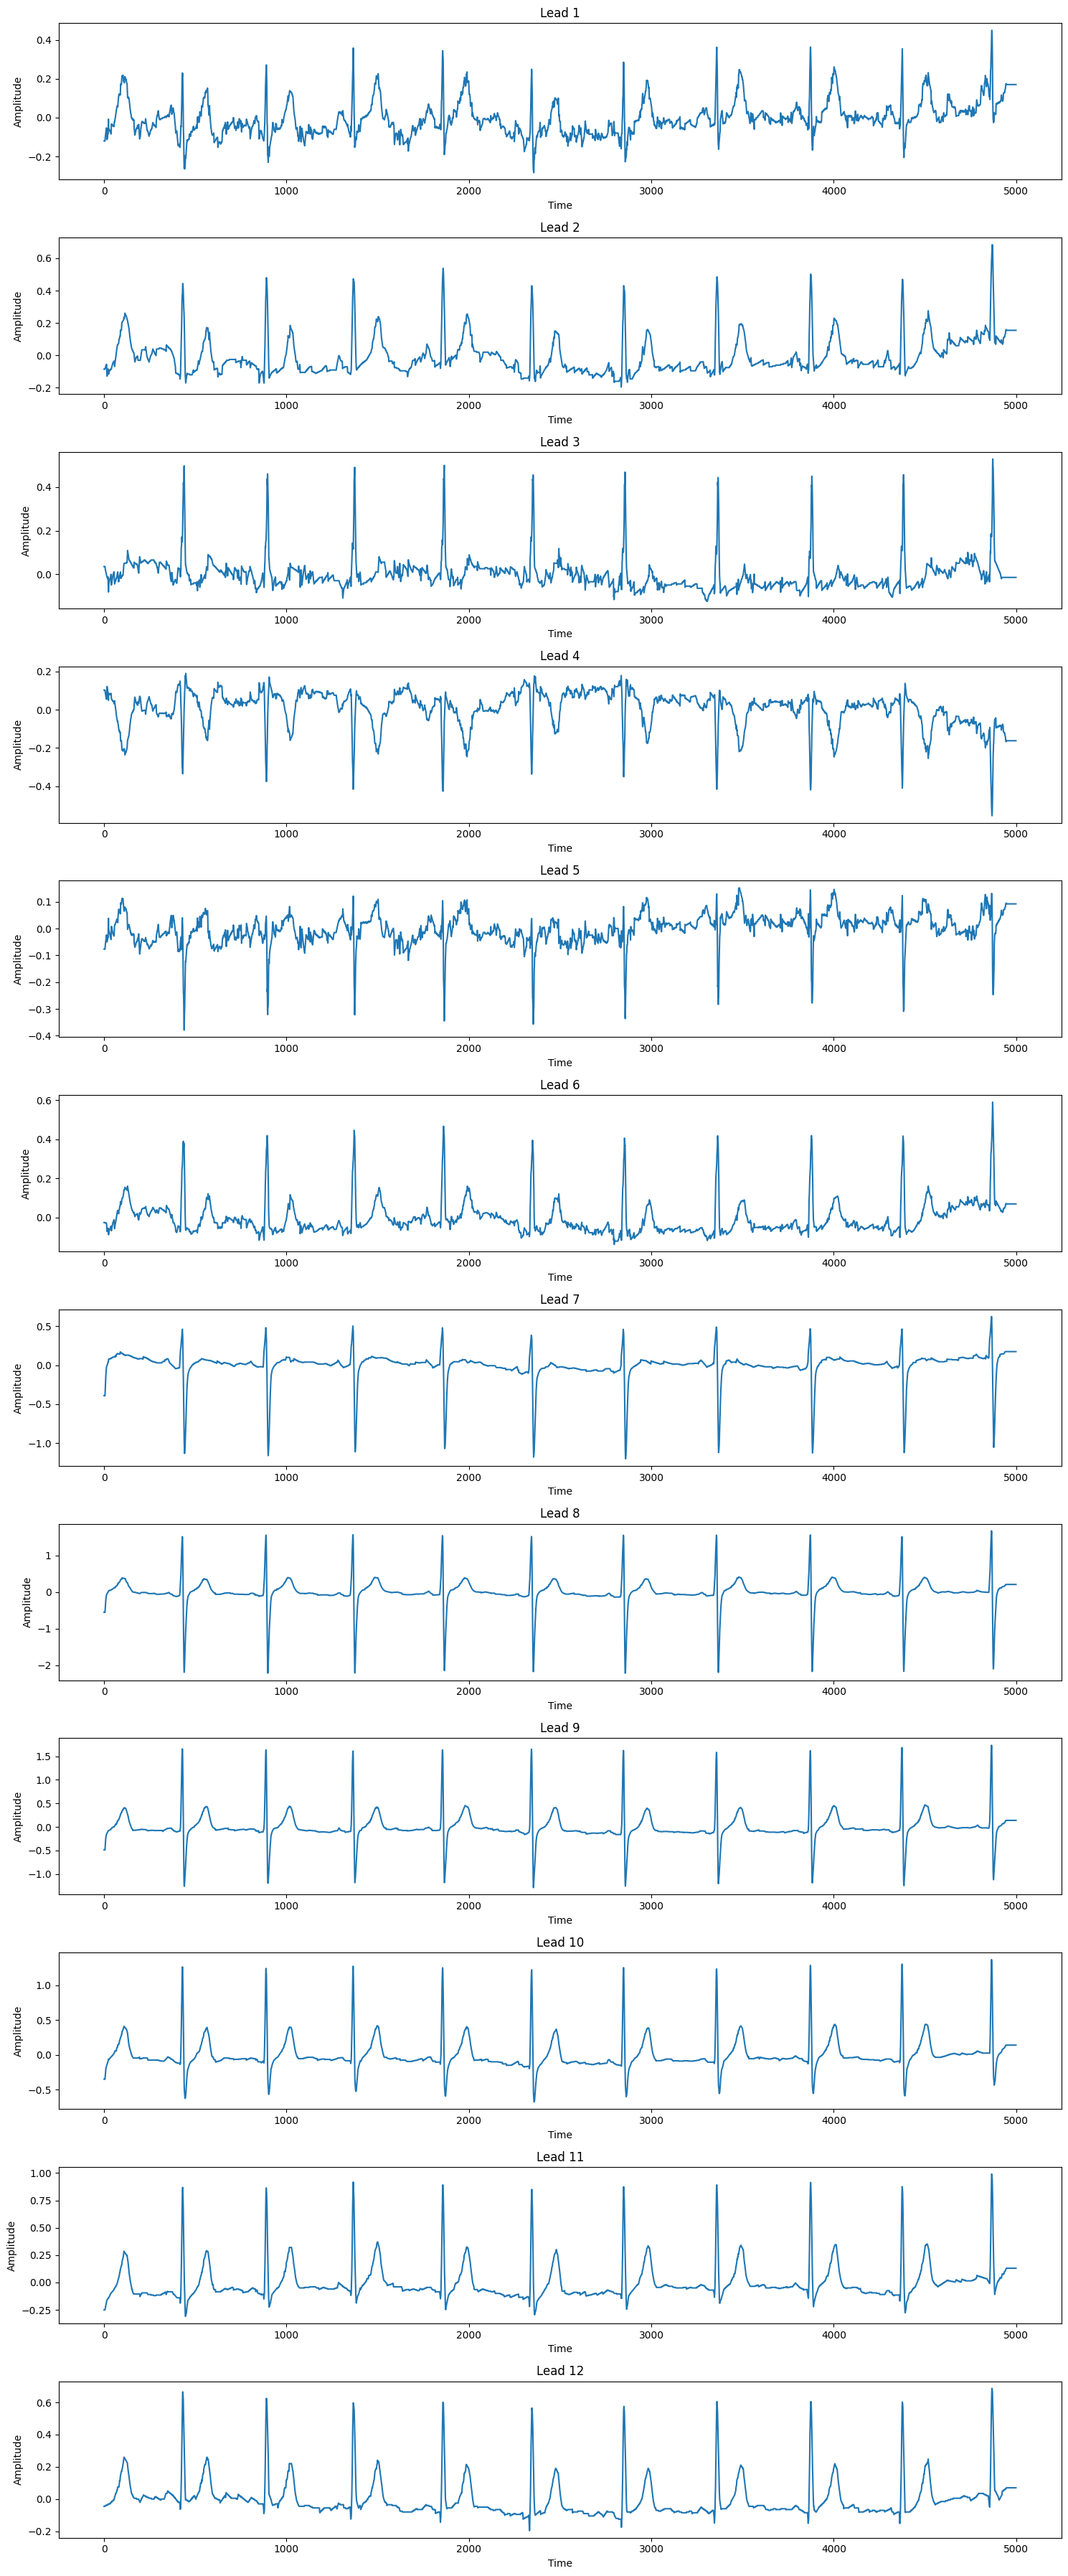

In [7]:
def visualize_ecg_with_predictions(ecg_data, predictions, labels=None):
    """
    Visualize ECG data with model predictions.
    
    Args:
        ecg_data: Raw ECG data
        predictions: Model predictions
        labels: List of label names
    """
    n_leads, n_samples = ecg_data.shape
    
    # Plot ECG data
    fig, axes = plt.subplots(n_leads, 1, figsize=(15, 3 * n_leads))
    if n_leads == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.plot(ecg_data[i])
        ax.set_title(f"Lead {i+1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()
    
    # Plot predictions
    if labels is not None and len(predictions) == len(labels):
        plt.figure(figsize=(10, 6))
        plt.bar(labels, predictions)
        plt.xticks(rotation=90)
        plt.xlabel("Labels")
        plt.ylabel("Probability")
        plt.title("Model Predictions")
        plt.tight_layout()
        plt.show()

# Visualize the ECG data if it was loaded successfully
try:
    visualize_ecg_with_predictions(ecg_data, None)
except NameError:
    print("ECG data not loaded. Please run 'make ptbxl-setup' first.")

## Complete Example

Here's a complete example of loading an ECG, preprocessing it, running inference, and visualizing the results.

Loaded ECG data with shape: (12, 5000)
Preprocessed ECG data with shape: torch.Size([1, 12000])
Model predictions shape: torch.Size([1, 187, 768])
Mismatch in prediction length (187) and label length (71)


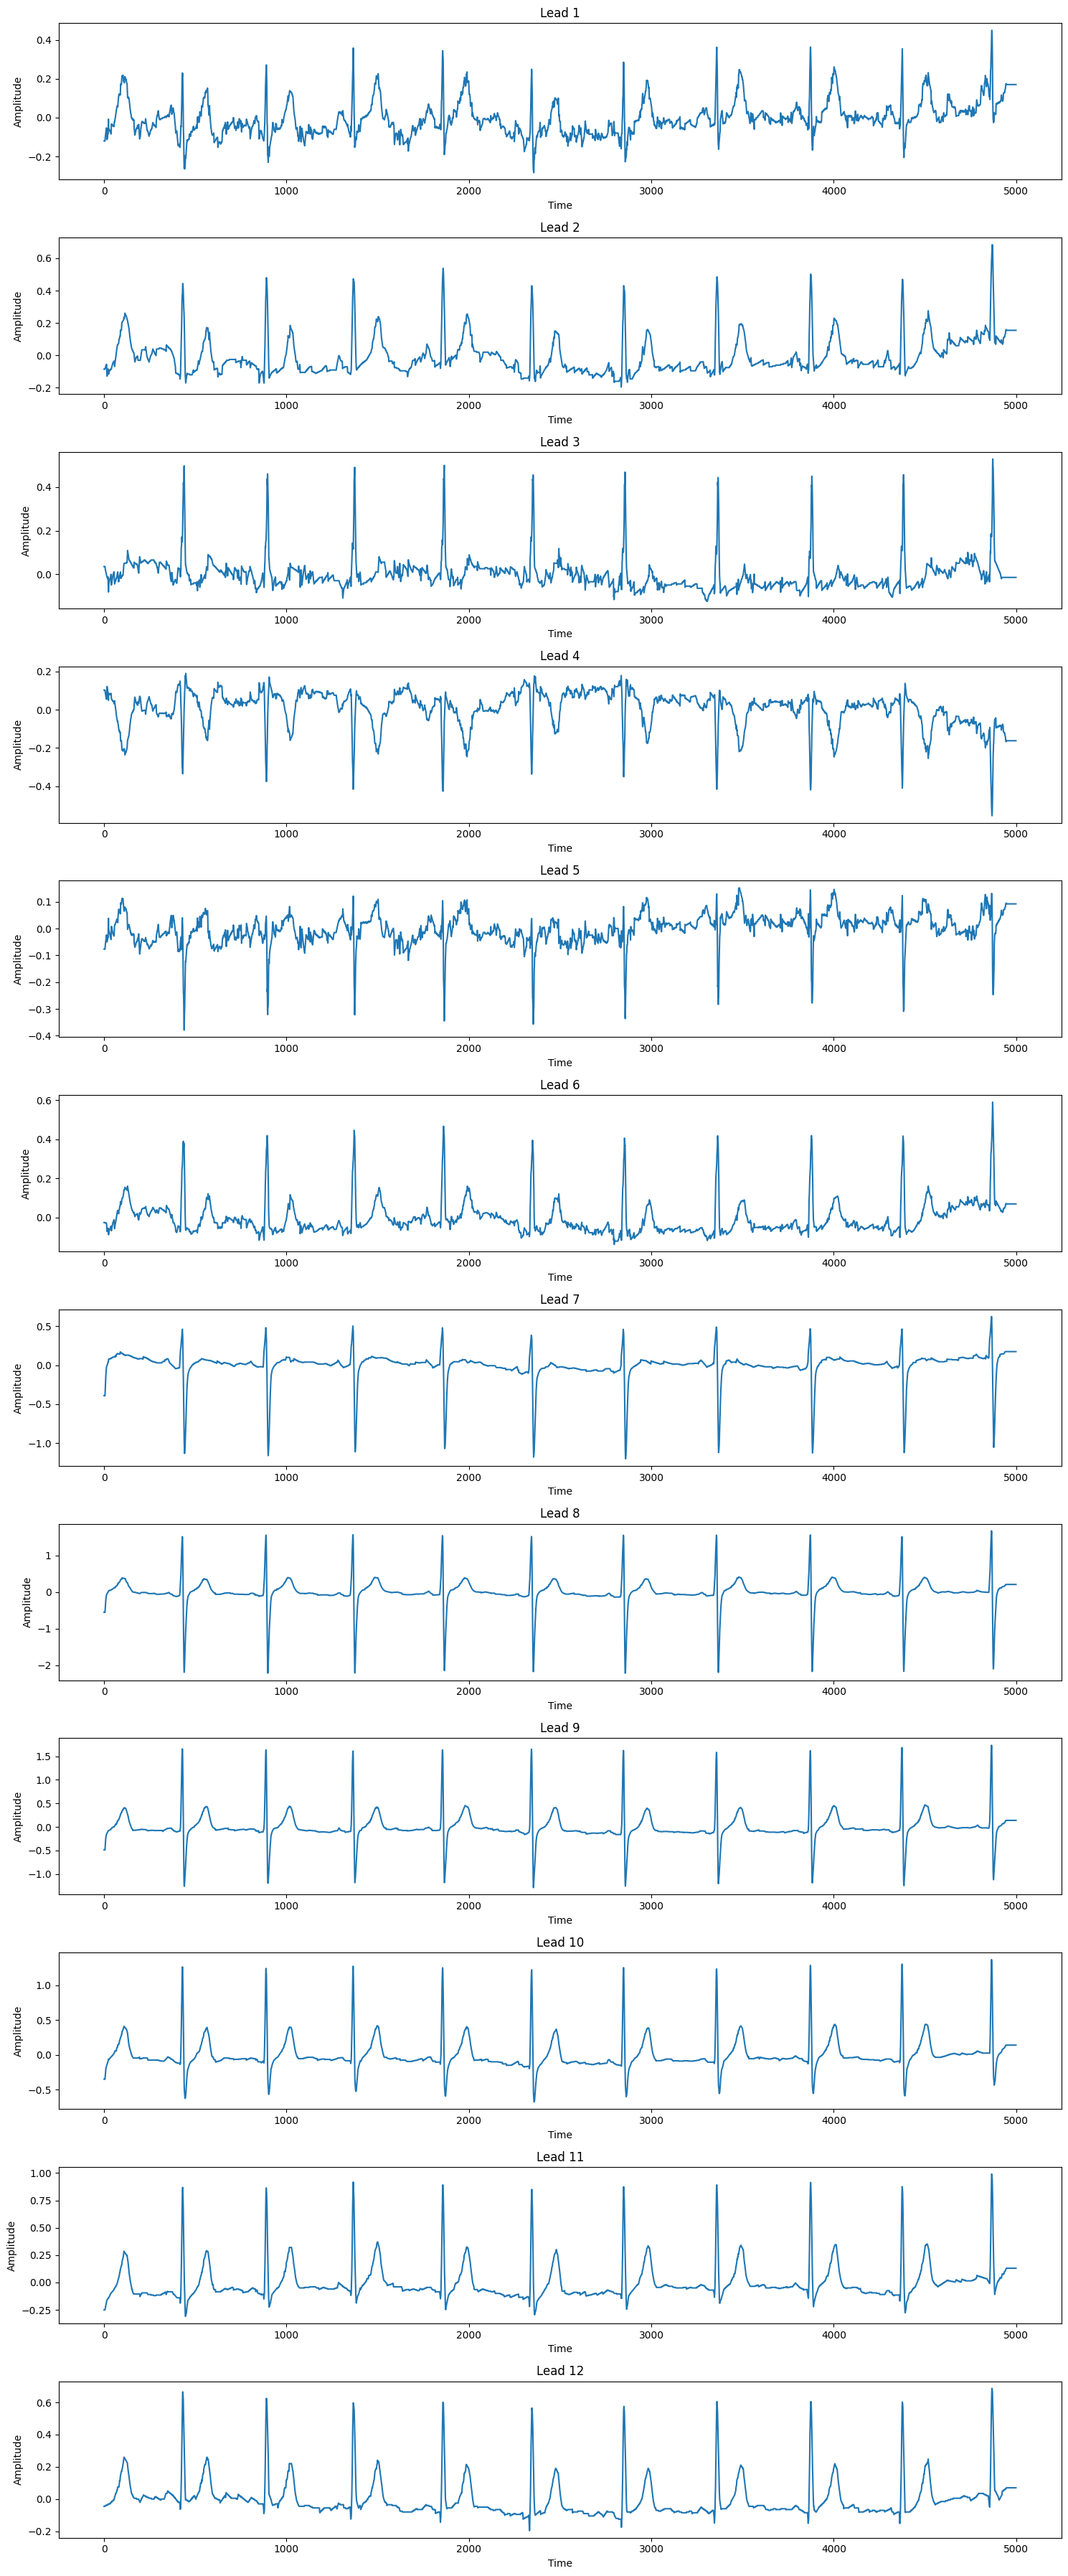

In [8]:
# Complete example
# Make sure you've run 'make ptbxl-setup' to download and process the data

try:
    # 1. Load ECG data
    sample_filename = df.iloc[0]['filename']
    ecg_path = os.path.join("data/ptbxl/processed", sample_filename)
    ecg_data = np.load(ecg_path)
    print(f"Loaded ECG data with shape: {ecg_data.shape}")
    
    # 2. Preprocess ECG data using the fixed function
    preprocessed_ecg = preprocess_ecg(ecg_data)
    print(f"Preprocessed ECG data with shape: {preprocessed_ecg.shape}")
    
    # 3. Run inference using the fixed function
    predictions = run_inference(model, preprocessed_ecg)
    print(f"Model predictions shape: {predictions[0].shape}")
    
    # 4. Visualize results
    # Get the column names from the CSV file (excluding the first 4 columns)
    label_names = df.columns[4:].tolist()
    # Get the predictions for the first sample
    pred_values = predictions[0][0].cpu().numpy()
    # Ensure the predictions and labels have the same length
    if len(pred_values) == len(label_names):
        visualize_ecg_with_predictions(ecg_data, pred_values, label_names)
    else:
        print(f"Mismatch in prediction length ({len(pred_values)}) and label length ({len(label_names)})")
        visualize_ecg_with_predictions(ecg_data, None)
except Exception as e:
    print(f"Error: {e}")
    print("Please ensure you've run 'make ptbxl-setup' to download and process the PTB-XL dataset.")

## Conclusion

In this notebook, we demonstrated how to use the HuBERT-ECG model for ECG classification. We covered loading a pre-trained model, preprocessing ECG data, running inference, and visualizing the results.

For more information, see the [HuBERT-ECG paper](https://www.medrxiv.org/content/10.1101/2024.11.14.24317328v1) and the [HuBERT-ECG GitHub repository](https://github.com/your-username/HuBERT-ECG).